In [1]:
import modbampy
from modbampy import ModBam

In [2]:
import pandas as pd

def retrievePositionsDF(path):
    names=["chromosome", "chromStart", "chromEnd", "geneName", "POO"]
    positions_df = pd.read_csv(path, names=names, sep="\t")
    return positions_df


In [3]:
dmr_coords_path = './feature_references/fig6_features/mm39_dmr_coordinates.bed'

def retrievePositionsFromDF(df):
    dict_of_coordinates = {}
    for line, value in df.iterrows():
        index = value[3]
        sub_dict = {
            "chromosome" : value[0],
            "chromStart" : value[1],
            "chromEnd" : value[2],
            "geneName" : value[3]
        }
        coord_dict = {index : sub_dict}
        dict_of_coordinates.update(coord_dict)
    return dict_of_coordinates

coord_dict = retrievePositionsFromDF(retrievePositionsDF(dmr_coords_path))

In [67]:
with ModBam('./data/prom_R10.4.1_E8.2_WGS_brain_DMR_regions.bam') as bam: 
    gene_list = []
    for gene in coord_dict.values():
        read_list = []
        for read in bam.reads(gene["chromosome"], gene["chromStart"], gene["chromEnd"]):
            read_sites = []
            for mod_position in read.mod_sites:
                mod_position_info = [gene["chromosome"], gene["chromStart"], gene["chromEnd"], gene["geneName"]]
                for datum in mod_position:
                    mod_position_info.append(datum)
                read_sites.append(mod_position_info)
            read_list.extend(read_sites)
        gene_list.extend(read_list)
    names=["chromosome", "chromStart", "chromEnd", "geneName", "read", "refPos", "qPos", "refStrand", "modStrand", "base", "mod", "score"]
    gene_df = pd.DataFrame(gene_list, columns=names)

In [75]:
gene_df["geneName"].value_counts()

Gnas1A           33452
Nespas-Gnasxl    24262
Mest             21002
Dlk1-Gtl2        19322
Grb10            18476
H19              14030
Rasgrf1          13090
Peg3             12754
Impact           12628
Zac1             12094
Igf2r            10436
Kcnq1ot1         10332
U2af1-rs1         9870
Peg10             9356
Snrpn             6866
Name: geneName, dtype: int64

In [131]:
def filterGeneStrands(all_imprinted_gene_df, gene): 
    
    gene_df = all_imprinted_gene_df.loc[(all_imprinted_gene_df["geneName"] == gene) & # filter to the gene
                                        (all_imprinted_gene_df["refPos"] >= all_imprinted_gene_df["chromStart"]) & # filter to gene coords
                                        (all_imprinted_gene_df["refPos"] <= all_imprinted_gene_df["chromEnd"])] 
    
    gene_df_pivot1 = gene_df.pivot(index=["chromosome", "chromStart", "chromEnd", "refStrand",  "geneName", "read", "refPos", "qPos"], columns="mod", values="score").reset_index()
    gene_df_pivot1["c"] = 255 - gene_df_pivot1[["h", "m"]].sum(axis=1)
    gene_df_melt = pd.melt(gene_df_pivot1, ["chromosome", "chromStart", "chromEnd", "refStrand", "geneName", "read", "refPos", "qPos"], ["h", "m", "c"], "mod", "score")
    gene_df_melt = gene_df_melt.loc[gene_df_melt["score"] >= 0.66*255]
    gene_df_melt.loc[gene_df_melt["refStrand"] == "-", "refPos"] = gene_df_melt["refPos"].sub(1, axis=0)

    return gene_df_melt

def pivotToHeatmap(df):
    df = df.pivot(index="read", columns=["refPos"], values="mod")
    df[df == "c"] = 0
    df[df == "h"] = 2
    df[df == "m"] = 1
    
    return df

def NADropper(df):
    new_df = df.dropna(thresh=len(df)*0.2, axis="columns") # removes CpGs present in fewer than 20% of reads
    new_df = new_df.dropna(thresh=len(new_df.columns)*0.8, axis="index") # removes reads with fewer than 80% of CpGs
    return new_df


<Figure size 640x480 with 0 Axes>

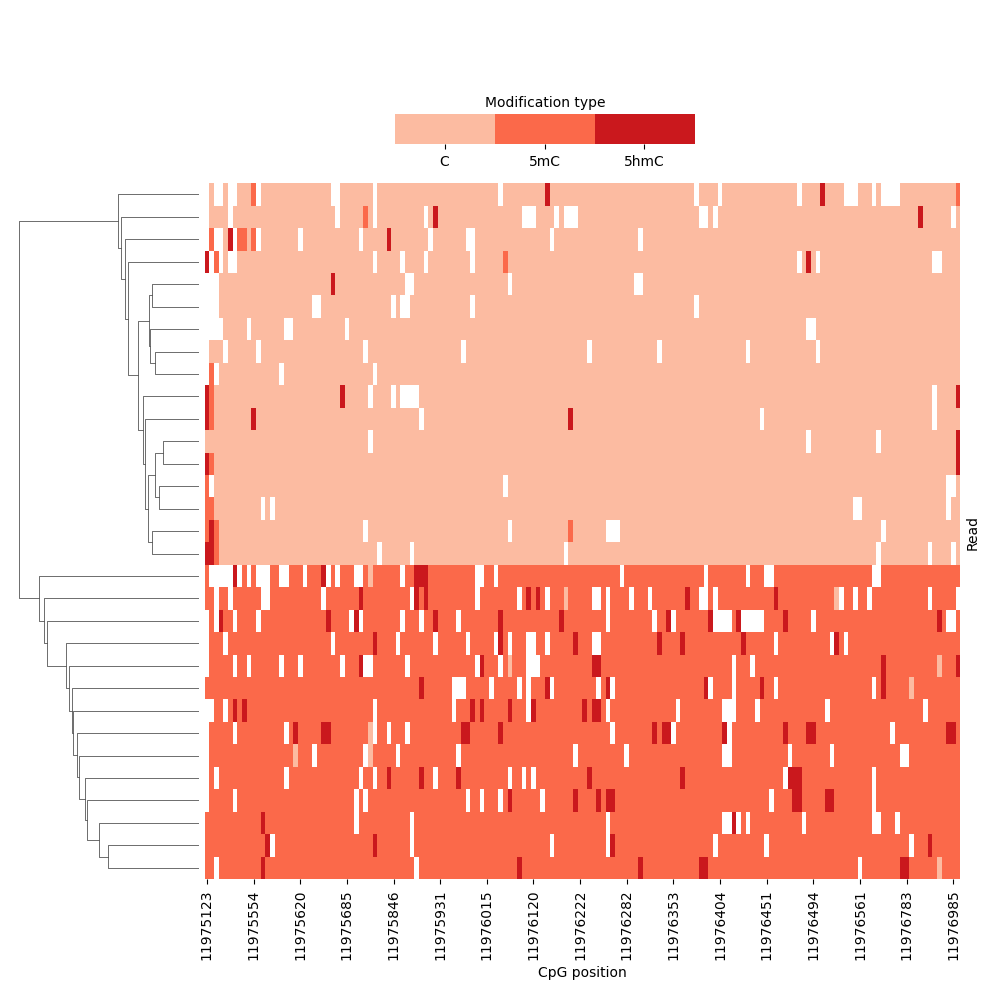

In [132]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt


Gnas1A_test = pivotToHeatmap(filterGeneStrands(gene_df, "Gnas1A"))
Grb10_test = pivotToHeatmap(filterGeneStrands(gene_df, "Grb10"))

fig = plt.figure()

g = sns.clustermap(NADropper(Grb10_test).fillna(-1), 
            mask=(NADropper(Grb10_test)).isna(), 
            xticklabels=10, yticklabels=False,
            col_cluster=False, row_cluster=True, 
            cmap=sns.color_palette("Reds", 3),
            cbar_kws={"ticks" : [0, 1, 2],
                      "orientation" : "horizontal"},
            figsize=(10, 10))

g.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
g.ax_cbar.set_xticks([0.33, 1, 1.66])
g.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
g.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
g.ax_heatmap.set_ylabel("Read")
g.ax_heatmap.set_xlabel("CpG position")

plt.show()


In [ ]:
def makeHeatmap(gene):

    fig = plt.figure()

    g = sns.clustermap(NADropper(Grb10_test).fillna(-1), 
                mask=(NADropper(Grb10_test)).isna(), 
                xticklabels=10, yticklabels=False,
                col_cluster=False, row_cluster=True, 
                cmap=sns.color_palette("Reds", 3),
                cbar_kws={"ticks" : [0, 1, 2],
                        "orientation" : "horizontal"},
                figsize=(10, 10))

    g.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
    g.ax_cbar.set_xticks([0.33, 1, 1.66])
    g.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
    g.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
    g.ax_heatmap.set_ylabel("Read")
    g.ax_heatmap.set_xlabel("CpG position")

    fig.show()